306


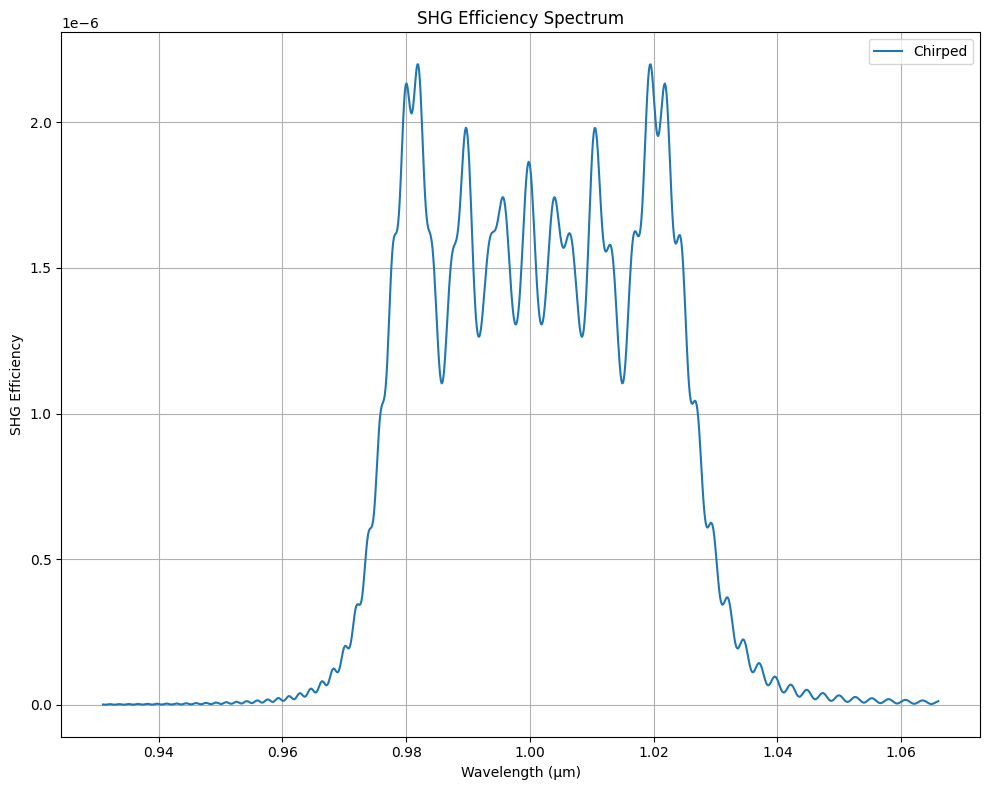

In [1]:
from syuron import shg3
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import List


# Generate chirped domain widths.
def create_chirped_domain_fn(L: float, Lambda0: float, chirp: float = 0.0) -> List[float]:
    widths: List[float] = []
    z = 0.0
    while z < L:
        # Compute current domain length based on chirp
        current = Lambda0 / (1 + chirp * z)
        widths.append(current / 2)  # Domain width is half of current length
        z += current  # Increment position
    return widths


# Pre-calculate the chirped domain widths.
chirped_domain_fn = create_chirped_domain_fn(2000, 7.2, 0.0001)


# Define a function to compute (kappa, domain_width) for a given domain index.
def domain_fn(domain_index: int) -> shg3.Domain:
    # Set kappa positive for even indices, negative for odd indices.
    kappa = 1.031E-05 if domain_index % 2 == 0 else -1.031E-05
    domain_width = chirped_domain_fn[domain_index]
    return shg3.Domain(domain_width, kappa)


# Pre-calculate the list of domain tuples.
# This is necessary because JAX cannot convert a function (or function pointer) into a jnp.array.
domain_stack: List[shg3.Domain] = [
    domain_fn(i) for i in range(len(chirped_domain_fn))]
print(len(domain_stack))

# Create the wavelength dimension as a list (converted from jnp.array).
wavelength_dim = jnp.linspace(0.931, 1.066, 1000).tolist()

# Define parameters for SHG analysis, using the precomputed list of domains.
params = shg3.Params(
    domain_stack_dim=domain_stack,  # Now a List[Tuple[kappa, domain_width]]
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
    mesh_density=300
)

# Run the SHG analysis with specified methods.
eff_tensor = shg3.analyze(params, shg3.use_mgoslt, shg3.solve_ncme)

# Plot the SHG Efficiency Spectrum.
plt.figure(figsize=(10, 8))
# Extract the efficiency line for plotting
eff_line = eff_tensor[0, 0, :, 0, 0]
plt.plot(wavelength_dim, eff_line, label="Chirped")
plt.xlabel("Wavelength (μm)")
plt.ylabel("SHG Efficiency")
plt.title("SHG Efficiency Spectrum")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()